In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install openpyxl

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle as cPickle
import pandas as pd
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
import sklearn.metrics
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from keras import regularizers
from keras import models
from openpyxl import Workbook

In [ ]:
path_data = "/content/drive/MyDrive/DP_OTG/data/"
path_model = "/content/drive/MyDrive/DP_OTG/Result/"
path_result = "/content/drive/MyDrive/DP_OTG/Result/"

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tạo từ điển 1-gram
def Dic_1_gram():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']
    return {aa: idx + 1 for idx, aa in enumerate(AA_list_sort)}

# Tạo k-mer từ chuỗi protein với kích thước k
def ProSentence(pro, K):
    return " ".join([pro[i: i + K] for i in range(len(pro) - K + 1)])

# Tham số
k = 1  # 1-gram
word_index1 = Dic_1_gram()
vocab_size = len(word_index1)

# Preprocessing dữ liệu kiểm tra và chuyển đổi chuỗi thành chỉ số
df_test = pd.read_csv(path_data+"Independent.csv", delimiter=',')

# Tạo k-mer cho mỗi chuỗi protein
df_test['k_mer'] = df_test['Sequence'].apply(lambda x: ProSentence(x, k))

# Chuyển đổi k-mer thành chỉ số
test_sequences = [
    [word_index1[aa] for aa in sentence.split()] for sentence in df_test['k_mer']
]

# Padding dữ liệu
MAX_SEQUENCE_LENGTH = len(df_test['k_mer'].iloc[0].split())  # Dùng độ dài của câu đầu tiên
Xtest = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Nhãn kiểm tra
ytest = df_test['Label'].values
ytest = np.array(ytest)
lb = LabelBinarizer()
ytest= lb.fit_transform(ytest)
ytest = to_categorical(ytest)
# In dữ liệu đã tokenized và các chỉ số
print(f"Tokenized sequences: {test_sequences[:2]}")
print(f"Xtest shape: {Xtest.shape}")
print(f"ytest shape: {ytest.shape}")



Tokenized sequences: [[4, 20, 7, 4, 13, 20, 10, 7, 17, 7, 11, 1, 3, 9, 16, 10, 17, 20, 3, 2, 11, 20, 1, 5, 17, 1, 18, 17, 16, 6, 3, 4, 14, 11, 4, 17, 2, 7, 17, 10, 7], [2, 13, 15, 18, 10, 3, 7, 3, 16, 10, 15, 10, 20, 7, 17, 15, 8, 12, 1, 1, 11, 15, 13, 13, 2, 4, 14, 8, 10, 19, 8, 3, 15, 13, 15, 7, 20, 1, 8, 2, 1]]
Xtest shape: (400, 41)
ytest shape: (400, 2)


Loaded best model successfully.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


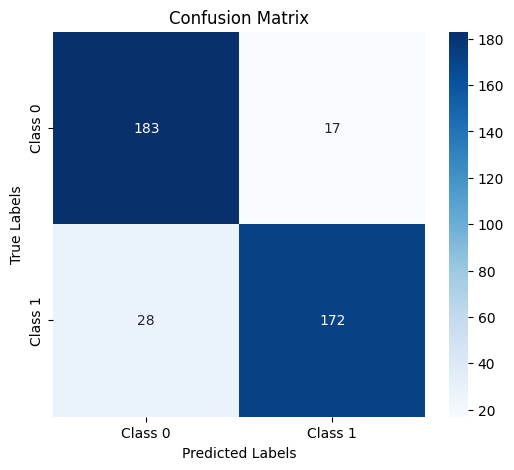

Kết quả đã được lưu vào /content/drive/MyDrive/DP_OTG/Result/ID_DP_OTG.xlsx


In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_auc_score

# Load mô hình tốt nhất
best_model_path = os.path.join(path_result, "DP_OTG.h5")
if os.path.exists(best_model_path):
    model = load_model(best_model_path)
    print("Loaded best model successfully.")
else:
    raise FileNotFoundError(f"Best model not found at {best_model_path}")

# Dự đoán xác suất của mỗi lớp
yprob = model.predict(Xtest)

# Lấy nhãn dự đoán và nhãn thực tế
test_preds = np.argmax(yprob, axis=1)
ytest_true = np.argmax(ytest, axis=1)

# Tính toán confusion matrix
conf_matrix = confusion_matrix(ytest_true, test_preds)
TN, FP, FN, TP = conf_matrix.ravel()

# Vẽ confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Tính toán AUC
auc_score = roc_auc_score(ytest[:, 1], yprob[:, 1])

# Lưu các giá trị vào DataFrame
data = {'TP': [TP], 'FP': [FP], 'TN': [TN], 'FN': [FN], 'AUC': [auc_score]}
df = pd.DataFrame(data)

# Đường dẫn lưu file kết quả
output_file = os.path.join(path_result, "ID_DP_OTG.xlsx")
df.to_excel(output_file, index=False)

print(f"Kết quả đã được lưu vào {output_file}")

